In [2]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

## Plots

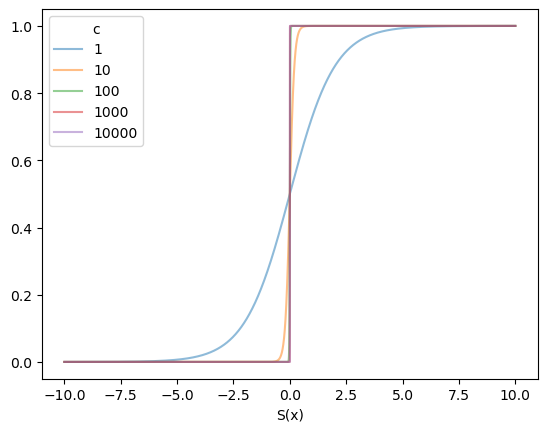

In [5]:
# plot a motivation figure for soft sign

fig, ax = plt.subplots(1, 1)
x_vals = np.linspace(-10, 10, 10001)

def stable_c_sigmoid(x, c):
    if x >= 0:
        return 1/(1 + np.exp(-1 * c * x))
    else:
        return np.exp(c * x)/(1 + np.exp(c * x))

for c in [1, 10, 100, 1000, 10000]:

    y_vals = [stable_c_sigmoid(x, c) for x in x_vals]
    ax.plot(x_vals, y_vals, label=str(c), alpha=0.5)

ax.legend(title="c")
plt.xlabel('x')
plt.xlabel('S(x)')
plt.savefig('figures/c_sigmoid_plot.pdf')

## load grid search results

In [3]:
gs_result = list()

gs_dir = os.path.join('logs', 'grid_search')
for sub_dir in os.listdir(gs_dir):
    full_dir_path = os.path.join(gs_dir, sub_dir)
    if os.path.isdir(full_dir_path):
        with open(os.path.join(full_dir_path, 'config.json'), "r") as fin:
            config_dict = json.load(fin)
        with open(os.path.join(full_dir_path, 'eval.json'), "r") as fin:
            eval_dict = json.load(fin)
        join = dict()
        for target in [config_dict, eval_dict]:
            for k, v in target.items():
                join[k] = v
        gs_result.append(join)

gs_result = pd.DataFrame(gs_result)

In [ ]:
gs_result.head()